In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Stroke Prediction with KNN

# Problem definition

Context

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information

1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Acknowledgements (Confidential Source) - Use only for educational purposes If you use this dataset in your research, please credit the author.

# Libraries

Let us import necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer

import missingno as msno

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.7f' % x)

# User Defined Functions

In [3]:
# For checking missing values and missing percent

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [4]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

# Data Gathering
- Read the csv

In [5]:
df = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [6]:
#df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [7]:
df.head()

id  gender        age  hypertension  heart_disease ever_married  \
0   9046    Male 67.0000000             0              1          Yes   
1  51676  Female 61.0000000             0              0          Yes   
2  31112    Male 80.0000000             0              1          Yes   
3  60182  Female 49.0000000             0              0          Yes   
4   1665  Female 79.0000000             1              0          Yes   

       work_type Residence_type  avg_glucose_level        bmi  \
0        Private          Urban        228.6900000 36.6000000   
1  Self-employed          Rural        202.2100000        NaN   
2        Private          Rural        105.9200000 32.5000000   
3        Private          Urban        171.2300000 34.4000000   
4  Self-employed          Rural        174.1200000 24.0000000   

    smoking_status  stroke  
0  formerly smoked       1  
1     never smoked       1  
2     never smoked       1  
3           smokes       1  
4     never smoked       1

# Data Preparation
- Get basic information from the dataset

Let's start by standardizing all column names.

In [8]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [9]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [10]:
df.shape

(5110, 12)

In [11]:
print (f' We have {df.shape[0]} instances with the {df.shape[1]-1} features and 1 target variable.')

 We have 5110 instances with the 11 features and 1 target variable.


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- We have both numerical and categorical variables (8 numerical, 4 categorical).
- The most important column is our target variable "stroke".
- Target variable is coded as **1** for positive cases and **0** for negative cases.
- "Hypertension" and "heart disease" columns are coded like "stroke" column.

In [13]:
df.describe().T

count          mean           std        min  \
id                5110.0000000 36517.8293542 21161.7216248 67.0000000   
age               5110.0000000    43.2266145    22.6126467  0.0800000   
hypertension      5110.0000000     0.0974560     0.2966067  0.0000000   
heart_disease     5110.0000000     0.0540117     0.2260630  0.0000000   
avg_glucose_level 5110.0000000   106.1476771    45.2835602 55.1200000   
bmi               4909.0000000    28.8932369     7.8540667 10.3000000   
stroke            5110.0000000     0.0487280     0.2153199  0.0000000   

                            25%           50%           75%           max  
id                17741.2500000 36932.0000000 54682.0000000 72940.0000000  
age                  25.0000000    45.0000000    61.0000000    82.0000000  
hypertension          0.0000000     0.0000000     0.0000000     1.0000000  
heart_disease         0.0000000     0.0000000     0.0000000     1.0000000  
avg_glucose_level    77.2450000    91.8850000   114.0900000   271.7400000  
bmi                  23.5000000    28.1000000    33.1000000    97.6000000  
stroke                0.0000000     0.0000000     0.0000000     1.0000000

- An overview of the values each column contains. Above we can see some basic descriptive statistics for all numeric columns.

In [14]:
df.describe(include=object).T

count unique           top  freq
gender          5110      3        Female  2994
ever_married    5110      2           Yes  3353
work_type       5110      5       Private  2925
residence_type  5110      2         Urban  2596
smoking_status  5110      4  never smoked  1892

- We can also analyze other data types. But we can not calculate a mean or a standard deviation for the object columns. However, it will still display some descriptive statistics

In [15]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

- Number of unique values in each column

In [16]:
df.duplicated().value_counts()

False    5110
dtype: int64

- There is no dublicated value in the dataset

In [17]:
missing (df)

Missing_Number  Missing_Percent
bmi                           201        0.0393346
id                              0        0.0000000
gender                          0        0.0000000
age                             0        0.0000000
hypertension                    0        0.0000000
heart_disease                   0        0.0000000
ever_married                    0        0.0000000
work_type                       0        0.0000000
residence_type                  0        0.0000000
avg_glucose_level               0        0.0000000
smoking_status                  0        0.0000000
stroke                          0        0.0000000

- Only the "bmi" column has 201 null values. We will fill in these values while defining X and y before modelling.

### Data Cleaning

In "id" column, all the values are unique. Let's drop the "id" column.

In [18]:
df.drop('id', axis=1, inplace=True)

In [19]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

- Before deeping into the analysis it would be benefical to examine the correlation among variables using heatmap.

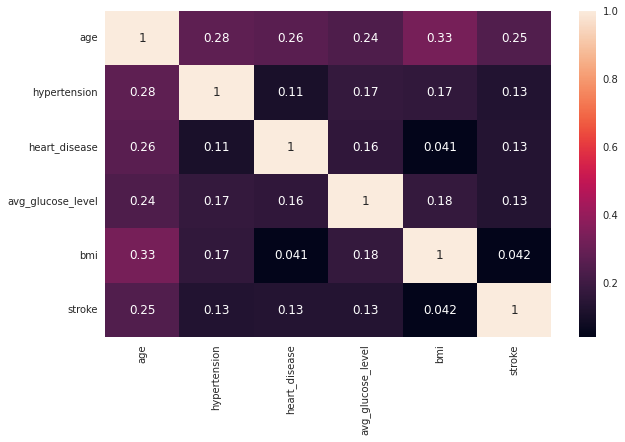

In [20]:
sns.heatmap(df.corr(), annot=True);

- Let's split our features into two part, numerical and categorical, for easing our further examination.

In [21]:
numerical= df.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


Categorical Columns: Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


### The Examination of Target Variable

In [22]:
first_looking("stroke")

column name    :  stroke
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    4861
1     249
Name: stroke, dtype: int64


In [23]:
df['stroke'].describe()

count   5110.0000000
mean       0.0487280
std        0.2153199
min        0.0000000
25%        0.0000000
50%        0.0000000
75%        0.0000000
max        1.0000000
Name: stroke, dtype: float64

In [24]:
print( f"Skewness: {df['stroke'].skew()}")

Skewness: 4.193284486071313


In [25]:
df['stroke'].iplot(kind='hist')

- "stroke" column is coded as **1** for positive cases (has a stroke) and **0** for negative cases (does not have a stroke).
- Approximately % 95 of our target variable is 'No stroke' (4861)
- %5 of the instances of our target variable is 'Stroke' (249)

### Numerical Features

In [26]:
df[numerical].head().T

0           1           2           3           4
age                67.0000000  61.0000000  80.0000000  49.0000000  79.0000000
hypertension        0.0000000   0.0000000   0.0000000   0.0000000   1.0000000
heart_disease       1.0000000   0.0000000   1.0000000   0.0000000   0.0000000
avg_glucose_level 228.6900000 202.2100000 105.9200000 171.2300000 174.1200000
bmi                36.6000000         NaN  32.5000000  34.4000000  24.0000000

In [27]:
df[numerical].describe().T

count        mean        std        min        25%  \
age               5110.0000000  43.2266145 22.6126467  0.0800000 25.0000000   
hypertension      5110.0000000   0.0974560  0.2966067  0.0000000  0.0000000   
heart_disease     5110.0000000   0.0540117  0.2260630  0.0000000  0.0000000   
avg_glucose_level 5110.0000000 106.1476771 45.2835602 55.1200000 77.2450000   
bmi               4909.0000000  28.8932369  7.8540667 10.3000000 23.5000000   

                         50%         75%         max  
age               45.0000000  61.0000000  82.0000000  
hypertension       0.0000000   0.0000000   1.0000000  
heart_disease      0.0000000   0.0000000   1.0000000  
avg_glucose_level 91.8850000 114.0900000 271.7400000  
bmi               28.1000000  33.1000000  97.6000000

In [28]:
df[numerical].iplot(kind='hist');

In [29]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

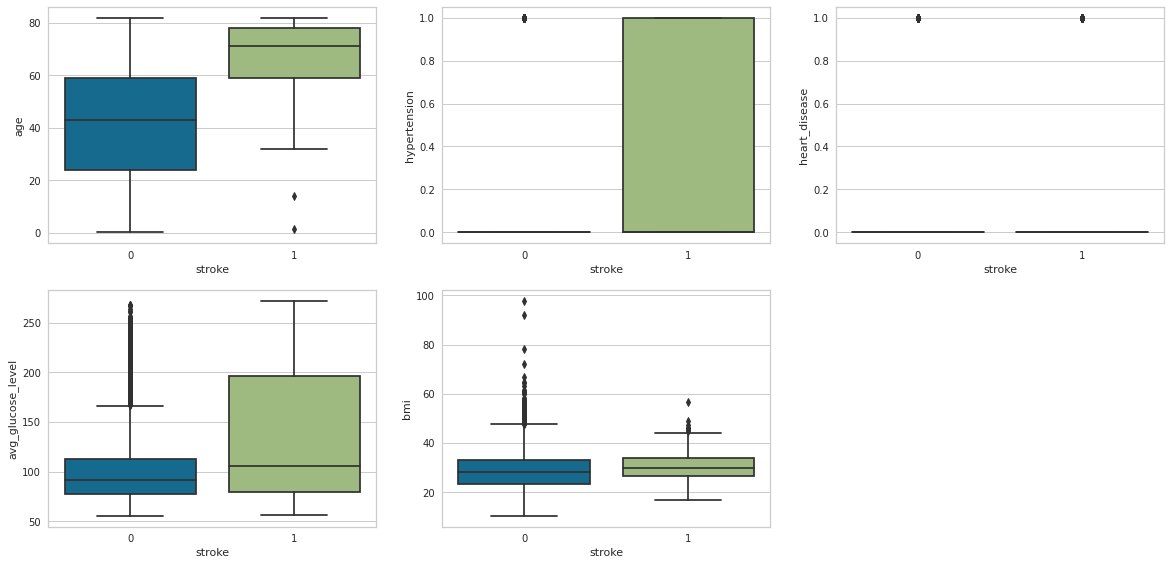

In [30]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='stroke',y=feature,data=df)

In [31]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

heart_disease       3.9472440
hypertension        2.7153917
avg_glucose_level   1.5722839
bmi                 1.0553402
dtype: float64

In [32]:
df[skew_cols.index].iplot(kind='hist');

In [33]:
df[skew_cols.index].iplot(kind='histogram',subplots=True,bins=50)

- Some features have skewness. Let's try to handle with their skewness by "np.log" and "PowerTransformer".

### Handling with Skewness

In [34]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols = skew_cols.drop(['heart_disease', 'hypertension'])
skew_cols

avg_glucose_level   1.5722839
bmi                 1.0553402
dtype: float64

**With np.log**

In [35]:
df_try = df.copy()
df_try = df[skew_cols.index].copy()
for col in skew_cols.index.values:
    df_try[col] = df_try[col].apply(np.log1p)
print(df_try[skew_cols.index].skew())
print()
df_try[skew_cols.index].iplot(kind='histogram',subplots=True,bins=50);

avg_glucose_level   0.8894698
bmi                 0.0319127
dtype: float64



**With Power Transformer**

In [36]:
df_trans = df[skew_cols.index].copy()
pt = PowerTransformer(method='yeo-johnson')
trans= pt.fit_transform(df_trans)
df_trans = pd.DataFrame(trans, columns =skew_cols.index )
print(df_trans.skew())
print()
df_trans.iplot(kind='histogram',subplots=True,bins=50);

avg_glucose_level    0.0845736
bmi                 -0.0007424
dtype: float64



In [37]:
df_trans.columns

Index(['avg_glucose_level', 'bmi'], dtype='object')

In [38]:
df.shape

(5110, 11)

In [39]:
df.drop(['avg_glucose_level', 'bmi'], axis=1, inplace=True)

In [40]:
df.shape

(5110, 9)

In [41]:
df = pd.concat([df, df_trans], axis=1)

In [42]:
df.shape

(5110, 11)

In [43]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'smoking_status', 'stroke',
       'avg_glucose_level', 'bmi'],
      dtype='object')

In [44]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. 
                  # Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

heart_disease   3.9472440
hypertension    2.7153917
dtype: float64

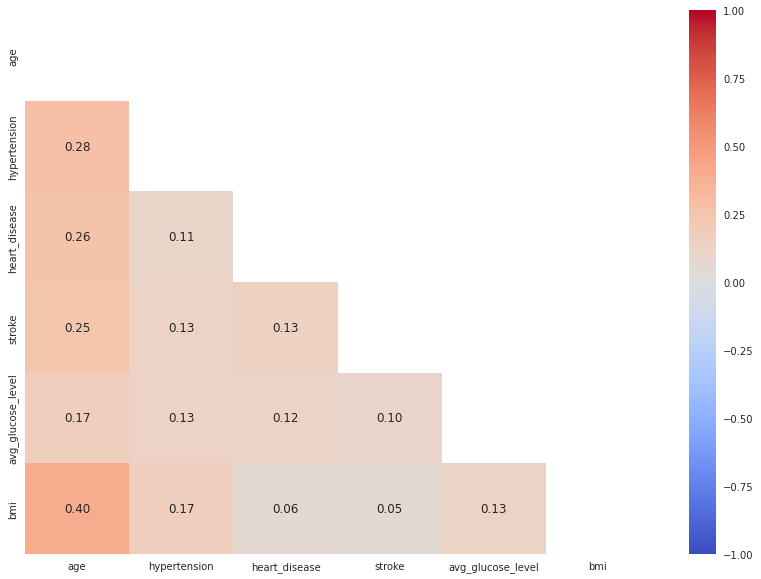

In [45]:
numerical= df.select_dtypes('number').columns

matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

In [46]:
df.head()

gender        age  hypertension  heart_disease ever_married      work_type  \
0    Male 67.0000000             0              1          Yes        Private   
1  Female 61.0000000             0              0          Yes  Self-employed   
2    Male 80.0000000             0              1          Yes        Private   
3  Female 49.0000000             0              0          Yes        Private   
4  Female 79.0000000             1              0          Yes  Self-employed   

  residence_type   smoking_status  stroke  avg_glucose_level        bmi  
0          Urban  formerly smoked       1          1.8623579  1.0256983  
1          Rural     never smoked       1          1.7004136        NaN  
2          Rural     never smoked       1          0.3947141  0.5773829  
3          Urban           smokes       1          1.4449411  0.7918351  
4          Rural     never smoked       1          1.4727475 -0.5679023

In [47]:
first_looking("age")

column name    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  104
78.0000000    102
57.0000000     95
52.0000000     90
54.0000000     87
51.0000000     86
45.0000000     85
79.0000000     85
53.0000000     85
55.0000000     83
50.0000000     83
59.0000000     80
31.0000000     79
49.0000000     79
56.0000000     77
37.0000000     76
61.0000000     76
47.0000000     75
44.0000000     75
62.0000000     74
40.0000000     74
63.0000000     74
41.0000000     73
60.0000000     72
38.0000000     72
39.0000000     71
42.0000000     71
32.0000000     71
80.0000000     70
43.0000000     70
34.0000000     68
58.0000000     68
48.0000000     66
5.0000000      65
23.0000000     64
65.0000000     62
26.0000000     62
46.0000000     62
71.0000000     61
18.0000000     60
66.0000000     60
17.0000000     60
81.0000000     60
20.0000000     59
8.0000000      58
13.0000000     57
25.0000000     57
33.0000000     57
82.0000000     56
2.0000000      

In [48]:
first_looking("hypertension")

column name    :  hypertension
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    4612
1     498
Name: hypertension, dtype: int64


In [49]:
first_looking("heart_disease")

column name    :  heart_disease
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    4834
1     276
Name: heart_disease, dtype: int64


In [50]:
first_looking("avg_glucose_level")

column name    :  avg_glucose_level
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3979
0.0357188     6
-0.0403620    5
-0.0343496    5
-0.3740669    5
-0.8767596    5
             ..
0.5442684     1
0.0531696     1
0.0917209     1
-1.2955083    1
-0.2846356    1
Name: avg_glucose_level, Length: 3979, dtype: int64


In [51]:
first_looking("bmi")

column name    :  bmi
--------------------------------
per_of_nulls   :  % 3.93
num_of_nulls   :  201
num_of_uniques :  418
NaN           201
0.1077814      41
0.0680845      38
-0.0398649     37
-0.1651199     37
-0.0262010     37
-0.2509930     37
-0.0811563     36
-0.6635407     36
-0.1229046     35
-0.1369240     34
-0.3985981     34
-0.2078124     34
-0.3388630     33
-0.4440264     31
0.1340154      31
-0.6474325     31
0.3127042      30
0.0547587      30
0.1988115      30
-0.1935279     30
0.4473761      30
-0.8623656     30
0.0279649      29
-0.0535786     29
-0.1792972     29
0.1600678      29
-0.5365516     29
-0.1089371     28
-0.5679023     28
-0.3686126     28
-0.5521946     28
0.0144962      28
0.5540780      28
0.0009792      28
-0.7286658     27
-0.9833393     27
0.2751219      27
-0.4288230     27
-0.2365446     27
-0.4136804     27
0.2371602      27
0.0813633      27
0.0945955      27
0.3867595      27
0.4593828      27
0.2876911      26
0.2116379      26
0.1209212   

### Categorical Features

In [52]:
df[categorical].head().T

0              1             2        3  \
gender                     Male         Female          Male   Female   
ever_married                Yes            Yes           Yes      Yes   
work_type               Private  Self-employed       Private  Private   
residence_type            Urban          Rural         Rural    Urban   
smoking_status  formerly smoked   never smoked  never smoked   smokes   

                            4  
gender                 Female  
ever_married              Yes  
work_type       Self-employed  
residence_type          Rural  
smoking_status   never smoked

In [53]:
df[categorical].describe().T

count unique           top  freq
gender          5110      3        Female  2994
ever_married    5110      2           Yes  3353
work_type       5110      5       Private  2925
residence_type  5110      2         Urban  2596
smoking_status  5110      4  never smoked  1892

### gender & stroke

In [54]:
first_looking("gender")

column name    :  gender
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


- We have 3 unique values. It seems that the "other" value is entered incorrectly. So let's drop it.

In [55]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [56]:
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [57]:
print(df.groupby('gender')['stroke'].mean().sort_values())
print()
df.groupby('gender')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

gender
Female   0.0470942
Male     0.0510638
Name: stroke, dtype: float64



### ever_married & stroke

In [58]:
first_looking("ever_married")

column name    :  ever_married
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Yes    3353
No     1756
Name: ever_married, dtype: int64


In [59]:
print(df.groupby('ever_married')['stroke'].mean().sort_values())
print()
df.groupby('ever_married')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

ever_married
No    0.0165148
Yes   0.0656129
Name: stroke, dtype: float64



### work_type & stroke

In [60]:
first_looking("work_type")

column name    :  work_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


In [61]:
print(df.groupby('work_type')['stroke'].mean().sort_values())
print()
df.groupby('work_type')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

work_type
Never_worked    0.0000000
children        0.0029112
Govt_job        0.0502283
Private         0.0509576
Self-employed   0.0793651
Name: stroke, dtype: float64



### residence_type & stroke

In [62]:
first_looking("residence_type")

column name    :  residence_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Urban    2596
Rural    2513
Name: residence_type, dtype: int64


In [63]:
print(df.groupby('residence_type')['stroke'].mean().sort_values())
print()
df.groupby('residence_type')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

residence_type
Rural   0.0453641
Urban   0.0520031
Name: stroke, dtype: float64



### smoking_status & stroke

In [64]:
first_looking("smoking_status")

column name    :  smoking_status
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64


In [65]:
print(df.groupby('smoking_status')['stroke'].mean().sort_values())
print()
df.groupby('smoking_status')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

smoking_status
Unknown           0.0304404
never smoked      0.0475687
smokes            0.0532319
formerly smoked   0.0791855
Name: stroke, dtype: float64



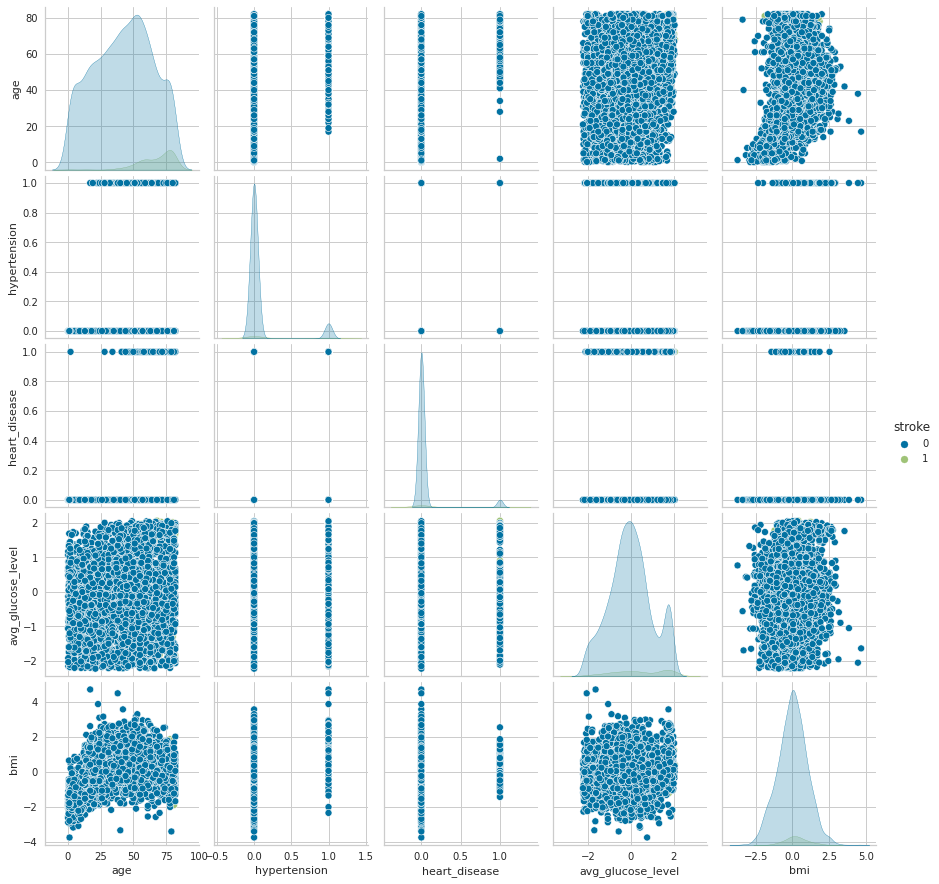

In [66]:
sns.pairplot(df, hue="stroke");

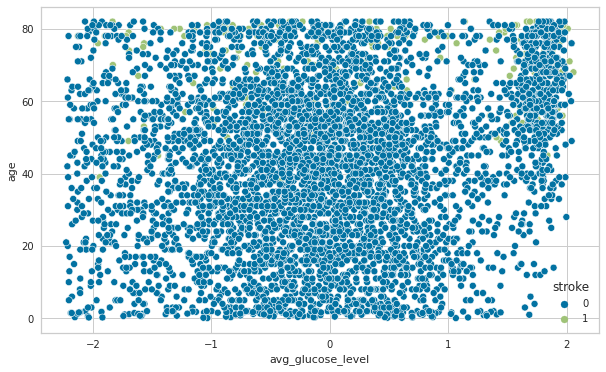

In [67]:
sns.scatterplot(x = 'avg_glucose_level', y = 'age', hue = 'stroke', data = df);

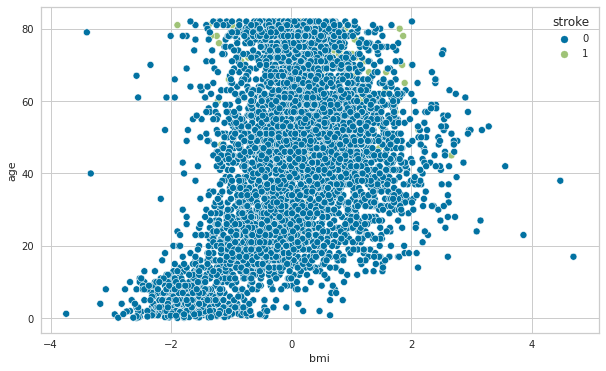

In [68]:
sns.scatterplot(x = 'bmi', y = 'age', hue = 'stroke', data = df);

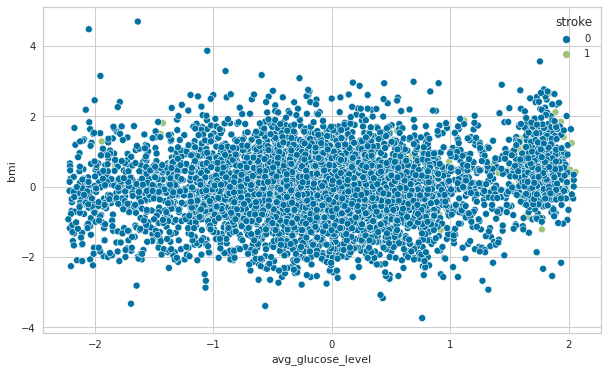

In [69]:
sns.scatterplot(x = 'avg_glucose_level', y = 'bmi', hue = 'stroke', data = df);

# Dummy Operations

In [70]:
df = pd.get_dummies(df, columns=['gender', 'ever_married',
       'work_type', 'residence_type', 'smoking_status',], drop_first=True)

In [71]:
df.head()

age  hypertension  heart_disease  stroke  avg_glucose_level  \
0 67.0000000             0              1       1          1.8623579   
1 61.0000000             0              0       1          1.7004136   
2 80.0000000             0              1       1          0.3947141   
3 49.0000000             0              0       1          1.4449411   
4 79.0000000             1              0       1          1.4727475   

         bmi  gender_Male  ever_married_Yes  work_type_Never_worked  \
0  1.0256983            1                 1                       0   
1        NaN            0                 1                       0   
2  0.5773829            1                 1                       0   
3  0.7918351            0                 1                       0   
4 -0.5679023            0                 1                       0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  1                        0                   0   
1                  0                        1                   0   
2                  1                        0                   0   
3                  1                        0                   0   
4                  0                        1                   0   

   residence_type_Urban  smoking_status_formerly smoked  \
0                     1                               1   
1                     0                               0   
2                     0                               0   
3                     1                               0   
4                     0                               0   

   smoking_status_never smoked  smoking_status_smokes  
0                            0                      0  
1                            1                      0  
2                            1                      0  
3                            0                      1  
4                            1                      0

<AxesSubplot:>

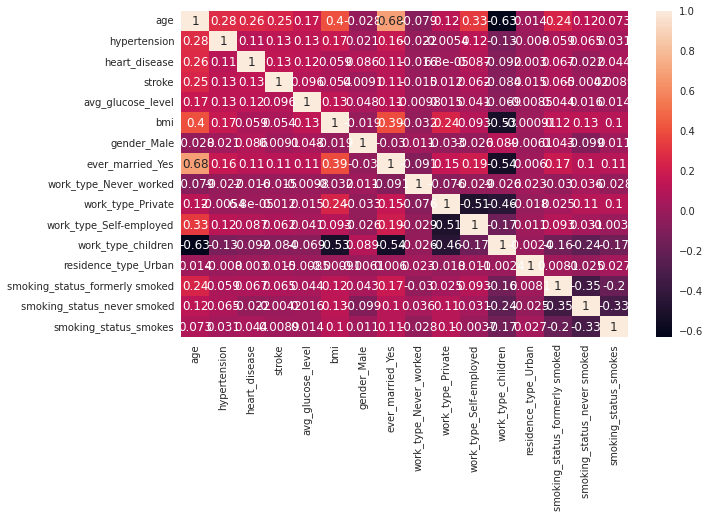

In [72]:
sns.heatmap(df.corr(), annot=True)

# Data Preprocessing

In [73]:
X = df.drop('stroke',axis=1)
y = df['stroke']

### Train / Test and Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Filling the Missing Values

In [75]:
X_train.bmi.value_counts(dropna=False)

NaN           136
-0.0398649     32
-0.6635407     31
-0.1651199     29
-0.4440264     27
-0.0535786     26
-0.0811563     26
-0.2078124     26
-0.3985981     26
-0.1369240     26
0.1077814      26
-0.0262010     26
0.0680845      24
-0.2509930     24
-0.4288230     23
0.1988115      23
0.0547587      23
-0.5679023     23
-0.4900065     22
0.4473761      22
-0.2365446     22
0.1730267      22
0.3867595      21
-0.1229046     21
0.2371602      21
-1.2374666     21
-0.3388630     21
-0.1089371     21
0.3127042      21
-0.5365516     20
-0.4136804     20
0.1340154      20
0.2116379      20
0.2625106      20
0.1600678      20
-0.9833393     20
0.2244207      20
-0.1935279     20
-0.2654969     20
0.5070292      20
-0.5209729     20
0.1470641      20
0.0009792      19
-0.5521946     19
0.0279649      19
0.6120708      19
0.0945955      19
0.0813633      19
0.3375518      19
-0.2946727     19
-0.8623656     19
0.5540780      18
-0.1792972     18
-0.3686126     18
-0.0950212     18
0.3745179 

In [76]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

X_train['bmi'] = imputer.fit_transform(X_train['bmi'].values.reshape(-1,1))[:,0]

In [77]:
X_test['bmi'] = imputer.fit_transform(X_test['bmi'].values.reshape(-1,1))[:,0]

- We imputed train and test sets seperately so that we did not have data leakage.

In [78]:
print(X_train.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


In [79]:
print(X_test.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


### Scaling

In [80]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [81]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implement KNN and Evaluate

In [82]:
knn = KNeighborsClassifier()

In [83]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [84]:
knn_pred = knn.predict(X_test_scaled)

In [85]:
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

[[1443    1]
 [  85    4]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.80      0.04      0.09        89

    accuracy                           0.94      1533
   macro avg       0.87      0.52      0.53      1533
weighted avg       0.94      0.94      0.92      1533



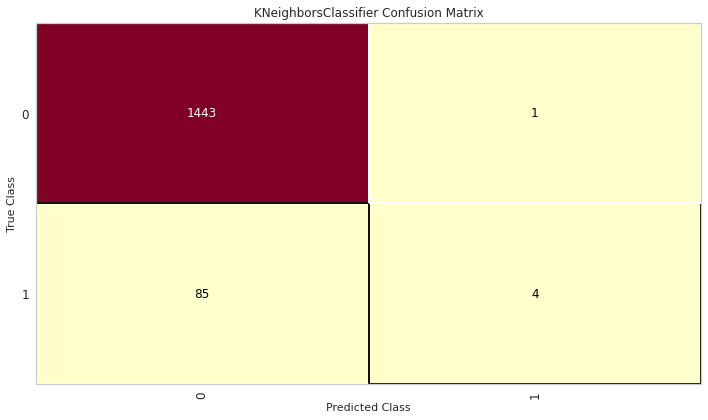

<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [86]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(knn)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show()

### Elbow Method for Choosing Reasonable K Values

In [87]:
error_rate = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(1 - recall_score(y_test, pred_i))

Text(0, 0.5, 'Error Rate')

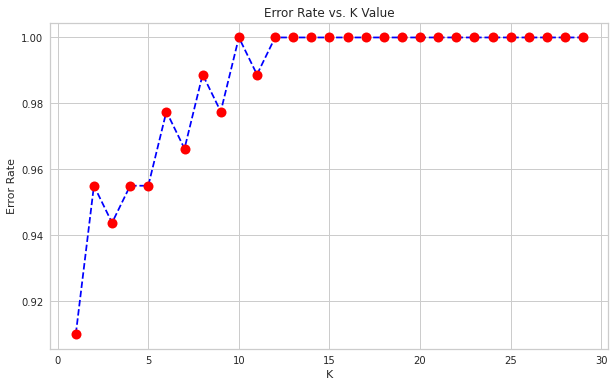

In [88]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

### Scores by Various K Values

In [89]:
# FIRST A QUICK COMPARISON TO OUR DEFAULT VALUE K=5
knn = KNeighborsClassifier()

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=5')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=5


[[1443    1]
 [  85    4]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.80      0.04      0.09        89

    accuracy                           0.94      1533
   macro avg       0.87      0.52      0.53      1533
weighted avg       0.94      0.94      0.92      1533



In [90]:
# WITH K=1
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=1


[[1383   61]
 [  81    8]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.12      0.09      0.10        89

    accuracy                           0.91      1533
   macro avg       0.53      0.52      0.53      1533
weighted avg       0.90      0.91      0.90      1533



In [91]:
# WITH K=2
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=2')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=2


[[1436    8]
 [  85    4]]


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.33      0.04      0.08        89

    accuracy                           0.94      1533
   macro avg       0.64      0.52      0.52      1533
weighted avg       0.91      0.94      0.92      1533



In [92]:
# WITH K=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=3


[[1431   13]
 [  84    5]]


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.28      0.06      0.09        89

    accuracy                           0.94      1533
   macro avg       0.61      0.52      0.53      1533
weighted avg       0.91      0.94      0.92      1533



In [93]:
# WITH K=4
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=4')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=4


[[1443    1]
 [  85    4]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.80      0.04      0.09        89

    accuracy                           0.94      1533
   macro avg       0.87      0.52      0.53      1533
weighted avg       0.94      0.94      0.92      1533



### Cross Validate For Optimal K Value

In [94]:
model = KNeighborsClassifier(n_neighbors=1)

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.0100780   0.0239134      0.9162011       0.0625000    0.0625000 0.0625000
2  0.0099127   0.0240803      0.9189944       0.1176471    0.1250000 0.1212121
3  0.0098531   0.0240097      0.9078212       0.0000000    0.0000000 0.0000000
4  0.0097005   0.0237179      0.9162011       0.1111111    0.1250000 0.1176471
5  0.0097563   0.0234857      0.9329609       0.1666667    0.1250000 0.1428571
6  0.0098410   0.0241137      0.9357542       0.1111111    0.0625000 0.0800000
7  0.0098319   0.0230019      0.9271709       0.1875000    0.1875000 0.1875000
8  0.0098073   0.0232925      0.9047619       0.0000000    0.0000000 0.0000000
9  0.0138659   0.0280001      0.9215686       0.1250000    0.1250000 0.1250000
10 0.0098052   0.0224347      0.9383754       0.2857143    0.2500000 0.2666667

In [95]:
df_scores.mean()[2:]

test_accuracy    0.9219810
test_precision   0.1167250
test_recall      0.1062500
test_f1          0.1103383
dtype: float64

### Gridsearch Method for Choosing Optimal K Values

In [96]:
knn_grid = KNeighborsClassifier()

In [97]:
k_values= range(1,30)

In [98]:
param_grid = {"n_neighbors":k_values, "p": [1,2], "weights": ['uniform', "distance"]}

In [99]:
knn_grid_model = GridSearchCV(knn_grid, param_grid, cv=10, scoring= 'recall')

In [100]:
knn_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [101]:
knn_grid_model.best_params_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [102]:
# NOW WITH K=1
knn = KNeighborsClassifier(n_neighbors=1, p=2, weights='uniform')

knn.fit(X_train_scaled,y_train)
pred = knn.predict(X_test_scaled)

print('WITH K=1')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=1


[[1383   61]
 [  81    8]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.12      0.09      0.10        89

    accuracy                           0.91      1533
   macro avg       0.53      0.52      0.53      1533
weighted avg       0.90      0.91      0.90      1533



# Conclusion

- Our results with the KNN model for this dataset are not very good.

- Although we did cross validation and found the most suitable parameters with GridSearch, we could not achieve the desired improvement in our results.

- After this point let's go on with other models.